In [ ]:
!pip install session-info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 8.2 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8046 sha256=e58dc776dc409fbf8561946e14b5d525b92305740b3b4d543b8682bbcfcf6920
  Stored in directory: /root/.cache/pip/wheels/5c/1b/4d/111d73980c5c6a8e5e5905a19eccc34296cb359cac54c6c5b9
Successfully built session-info


In [ ]:
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [ ]:
import tensorflow as tf
print(tf.__version__) # Verificar 2.9.0

2.9.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Add
from keras.utils.vis_utils import plot_model

from numpy.linalg import norm
import pandas as pd

import sklearn.metrics

from keras import regularizers as l 

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import os

from matplotlib.ticker import FormatStrFormatter

import time

from scipy import interpolate

In [ ]:
print(os.getcwd())

/content


In [ ]:
os.chdir('/content/drive/MyDrive/Tesis Maestría /Codigos depurados/LPAR/ExperimentoA')
print(os.getcwd())

/content/drive/MyDrive/Tesis Maestría /Codigos depurados/LPAR/ExperimentoA


In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
def load_data():
  mnist = keras.datasets.mnist
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train, X_test = X_train / 255.0, X_test / 255.0
  X_train = X_train.reshape(len(y_train),784)
  X_test  = X_test.reshape(len(y_test),784)

  y_train_onehot = keras.utils.to_categorical(y_train)
  y_test_onehot =  keras.utils.to_categorical(y_test)

  print(f'Conjunto de datos cargados')
  print(f'Tamaño imágenes de entrenamiento {X_train[:10000].shape}')
  print(f'Tamaño imágenes de test {X_test.shape}')
  print(f'Datos por cada etiqueta en X train {np.bincount(y_train[:10000])}')
  return X_train[:10000], X_test, y_train_onehot[:10000], y_test_onehot, y_train[:10000], y_test

In [ ]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()

11490434/11490434 [==============================] - 2s 0us/step
Conjunto de datos cargados
Tamaño imágenes de entrenamiento (10000, 784)
Tamaño imágenes de test (10000, 784)
Datos por cada etiqueta en X train [1001 1127  991 1032  980  863 1014 1070  944  978]


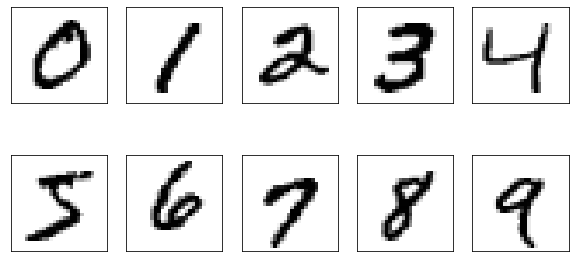

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gist_yarg')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

## Modelo con $n$ saltos residuales

In [ ]:
def skip_conection(dense_input, n, regular_l):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    return skip_conection(Add()([dense_input, resDense]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  return Add()([dense_input, resDenseo])

In [ ]:
def load_model(n, regular_l):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20, activation  ='relu', kernel_regularizer=regular_l)(inputs)
  
  skip_final = skip_conection(dense1, n, regular_l)

  outputs = Dense(10, activation='softmax', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=100, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
      
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

In [ ]:
generator = DataGenerator(images=X_train, labels=y_train, batch_size=100, shuffle=True)
n_batches = len(generator)
n_batches

100

In [ ]:
def lipschitz_bound(modelWeigts):
  numberLayers = len(modelWeigts)
  LipsBound = np.linalg.norm(modelWeigts[0], ord=2)     # Norma espectral (2) capa 1
  if LipsBound == 0: LipsBound = 1

  for rc in np.arange(2,numberLayers-2,2):              # En los indices de las capas residuales
    try: 
      LipsBound *= (1 + np.linalg.norm(modelWeigts[rc], ord=2))
    except:
      LipsBound *= 1
  
  LipsBound *= np.linalg.norm(modelWeigts[numberLayers-2], ord=2) # Capa de salida

  return  LipsBound

##  Funciones graficar 

In [ ]:
def graphGridAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Training Accuracy', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ Training Accuracy',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ Validation Accuracy',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'Accuracy',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.grid()
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.tight_layout()
  nameFile = 'presicionModelo' + str(skip) + 'G' +'.pdf'
  #plt.savefig(nameFile) 
  #plt.show()



def graphAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Training Accuracy', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ Training Accuracy',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ Validation Accuracy',
                  alpha=0.2, color = '#ff5271')
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  #plt.legend(fontsize=36, loc ='lower right')
  #plt.savefig(nameFile) 
  #plt.show()


In [ ]:
def graphGridLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  nameFile = 'cotaLipschitzModelo' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelo' + str(skip) +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelolog' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  nameFile = 'cotaLipschitzModelolog' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Lost Training', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ Lost Training', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Lost Validation', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ Lost Validation',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'funcionPerdidaModelo' + str(skip) + 'G' + '.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Lost Training', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ Lost Training', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Lost Validation', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ Lost Validation',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  nameFile = 'funcionPerdidaModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización Alternante cota Lipschitz

In [ ]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, Model = None, name="adaptativeRegularLB"):
        super().__init__(name=name)
        self.Model = Model

    def call(self, y_true, y_pred):
        self.Model._callable_losses.clear()
        cce = tf.keras.losses.CategoricalCrossentropy()
        loss = tf.cast(cce(y_true, y_pred), "float32")
        self.eig_values_radom(self.Model)
        loss += sum(self.Model.losses)
        return  loss 

    def eig_values_radom(self, Model):
      allLayers = self.Model.layers
      nLayers = len(allLayers)
      randomLayer = np.random.choice(np.append([1], [np.arange(2,nLayers,2)]), size=1)[0]
      EigVal = np.linalg.norm(allLayers[randomLayer].get_weights()[0], ord=2)
      self.Model.add_loss(lambda: EigVal*tf.norm(allLayers[randomLayer].trainable_variables[0], ord=2))
      #self.Model.add_loss(lambda: EigVal*tf.reduce_sum(tf.square(allLayers[randomLayer].trainable_variables[0])))
      return 

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneral = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []
  
  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,l.l2(0))

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          lossC = CustomLoss(Model = model)
          loss = lossC(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train_onehot[test_index], y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)

  #graphGridAcc(skip)
  #graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  #graphGridLipschtiz(skip)
  #graphLipschtiz(skip)
  #graphGridLipschtizlog(skip)
  #graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  #graphGridLoss(skip)
  #graphLoss(skip)

  resultGeneral[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneral), 'ResultadosExperimentoALB.csv')


Modelo : 4 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 181.24709272384644 en k-fold 1
80
Tiempo total 156.73066902160645 en k-fold 2
80
Tiempo total 157.17247772216797 en k-fold 3
80
Tiempo total 157.70796036720276 en k-fold 4
80
Tiempo total 157.34672141075134 en k-fold 5
Mean diference train and validation
0.005099559071063981
Area std train 
0.08914846181869507
Area std test
0.10881072999054954
Modelo : 6 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 182.5286626815796 en k-fold 1
80
Tiempo total 174.97465538978577 en k-fold 2
80
Tiempo total 177.1969518661499 en k-fold 3
80
Tiempo total 174.1215946674347 en k-fold 4
80
Tiempo total 175.7730188369751 en k-fold 5
Mean diference train and validation
0.0063582872688770255
Area std train 
0.06793340668082237
Area std te

### Evaluación en test de los modelos 

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneral[skip][5])
  std_test = np.std(resultGeneral[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 4, test 89.08 +/- 0.273
Modelo 6, test 90.34 +/- 0.469
Modelo 8, test 91.52 +/- 0.504


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneral[skip][0][x][-1] for x in resultGeneral[skip][0]])
  std_train = np.std([resultGeneral[skip][0][x][-1] for x in resultGeneral[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 4, train 90.70 +/- 0.374
Modelo 6, train 92.77 +/- 0.140
Modelo 8, train 94.42 +/- 0.632


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L2

### Sintonización hiper-parámetro

In [ ]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ l.l2(0.1), l.l2(0.01), l.l2(0.001), l.l2(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l2}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.10000000149011612
Kfold 1 acc train 0.8546249866485596, acc test 0.8349999785423279
Kfold 2 acc train 0.8424999713897705, acc test 0.8500000238418579
Kfold 3 acc train 0.8351250290870667, acc test 0.8314999938011169
Kfold 4 acc train 0.8486250042915344, acc test 0.8485000133514404
Kfold 5 acc train 0.8403750061988831, acc test 0.8289999961853027
Fin modelo: promedio acc train 0.8442499995231628,std 0.006754617409830538
Fin modelo: promedio acc test 0.8388000011444092,std 0.008755582464084068


Modelo 4, parametro 0.009999999776482582
Kfold 1 acc train 0.9548749923706055, acc test 0.906000018119812
Kfold 2 acc train 0.9390000104904175, acc test 0.9304999709129333
Kfold 3 acc train 0.9463750123977661, acc test 0.9330000281333923
Kfold 4 acc train 0.9415000081062317, acc test 0.921999990940094
Kfold 5 acc train 0.9478750228881836, acc test 0.9110000133514404
Fin modelo: promedio acc train 0.9459250092506408,std 0.005507149840412815
Fin modelo: promedio acc test 0.920

In [ ]:
regularParameters = {4: l.l2(0.01), 6: l.l2(0.01), 8: l.l2(0.01)}
regularParameters

{4: <keras.regularizers.L2 at 0x7fb3d7227580>,
 6: <keras.regularizers.L2 at 0x7fb3b3f38f40>,
 8: <keras.regularizers.L2 at 0x7fb3b3f38b50>}

### Entrenamiento

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneralL2 = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []

  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,regularParameters[skip])
    model.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics =['accuracy'])
    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      
      for batch in range(n_batches):
        x, y = generator[batch]
        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
          loss += tf.add_n(model.losses)
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()
      
      y_ = model.predict(X_train[test_index], verbose=0) # Validation predictions

      loss_val[epoch] = ce_loss(y_true= keras.utils.to_categorical(y_train[test_index], num_classes=10), 
                                y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))
      LB_1[epoch] = lipschitz_bound(model.get_weights())

    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)


  #graphGridAcc(skip)
  #graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  #graphGridLipschtiz(skip)
  #graphLipschtiz(skip)
  #graphGridLipschtizlog(skip)
  #graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  #graphGridLoss(skip)
  #graphLoss(skip)

  

  resultGeneralL2[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL2), 'ResultadosExperimentoALBL2.csv')

Modelo : 4 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 120.81126856803894 en k-fold 1
80
Tiempo total 122.94959831237793 en k-fold 2
80
Tiempo total 121.05908393859863 en k-fold 3
80
Tiempo total 119.71034169197083 en k-fold 4
80
Tiempo total 122.81388592720032 en k-fold 5
Mean diference train and validation
0.011554119546413406
Area std train 
0.110258299857378
Area std test
0.13516193044772887
Modelo : 6 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 141.53112030029297 en k-fold 1
80
Tiempo total 142.68419313430786 en k-fold 2
80
Tiempo total 142.6655569076538 en k-fold 3
80
Tiempo total 144.74490642547607 en k-fold 4
80
Tiempo total 141.946608543396 en k-fold 5
Mean diference train and validation
0.016801204863389332
Area std train 
0.07298453897237778
Area std test

### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneralL2[skip][5])
  std_test = np.std(resultGeneralL2[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 4, test 92.02 +/- 0.270
Modelo 6, test 92.30 +/- 0.156
Modelo 8, test 91.66 +/- 0.627


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneralL2[skip][0][x][-1] for x in resultGeneralL2[skip][0]])
  std_train = np.std([resultGeneralL2[skip][0][x][-1] for x in resultGeneralL2[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 4, train 94.81 +/- 0.267
Modelo 6, train 95.66 +/- 0.436
Modelo 8, train 95.68 +/- 0.701


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L1

### Sintonización hiper-parámetro

In [ ]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ l.l1(0.1), l.l1(0.01), l.l1(0.001), l.l1(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l1}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.10000000149011612
Kfold 1 acc train 0.11337500065565109, acc test 0.10999999940395355
Kfold 2 acc train 0.11287499964237213, acc test 0.1120000034570694
Kfold 3 acc train 0.11249999701976776, acc test 0.11349999904632568
Kfold 4 acc train 0.11150000244379044, acc test 0.11749999970197678
Kfold 5 acc train 0.1132500022649765, acc test 0.11050000041723251
Fin modelo: promedio acc train 0.11270000040531158,std 0.0006736094682305085
Fin modelo: promedio acc test 0.11270000040531158,std 0.002694438425944872


Modelo 4, parametro 0.009999999776482582
Kfold 1 acc train 0.8641250133514404, acc test 0.843999981880188
Kfold 2 acc train 0.8662499785423279, acc test 0.8619999885559082
Kfold 3 acc train 0.8737499713897705, acc test 0.8705000281333923
Kfold 4 acc train 0.8768749833106995, acc test 0.8619999885559082
Kfold 5 acc train 0.878000020980835, acc test 0.8579999804496765
Fin modelo: promedio acc train 0.8717999935150147,std 0.005616159941162176
Fin modelo: promedio acc

In [ ]:
regularParameters = {4: l.l1(0.0001), 6: l.l1(0.0001), 8: l.l1(0.0001)}
regularParameters

{4: <keras.regularizers.L1 at 0x7fb3b3f31fd0>,
 6: <keras.regularizers.L1 at 0x7fb3b3f31cd0>,
 8: <keras.regularizers.L1 at 0x7fb3b3f31160>}

### Entrenamiento

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneralL1 = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []

  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,regularParameters[skip])
    model.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics =['accuracy'])
    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      
      for batch in range(n_batches):
        x, y = generator[batch]
        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
          loss += tf.add_n(model.losses)
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()
      
      y_ = model.predict(X_train[test_index], verbose=0) # Validation predictions

      loss_val[epoch] = ce_loss(y_true= keras.utils.to_categorical(y_train[test_index], num_classes=10), 
                                y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))
      LB_1[epoch] = lipschitz_bound(model.get_weights())

    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)


  #graphGridAcc(skip)
  #graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  #graphGridLipschtiz(skip)
  #graphLipschtiz(skip)
  #graphGridLipschtizlog(skip)
  #graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  #graphGridLoss(skip)
  #graphLoss(skip)

  resultGeneralL1[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL1), 'ResultadosExperimentoALBL1.csv')

Modelo : 4 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 122.16723322868347 en k-fold 1
80
Tiempo total 120.3919370174408 en k-fold 2
80
Tiempo total 122.4920175075531 en k-fold 3
80
Tiempo total 120.85905456542969 en k-fold 4
80
Tiempo total 119.83607339859009 en k-fold 5
Mean diference train and validation
0.022379982055028284
Area std train 
0.06623880937695503
Area std test
0.09033971891805793
Modelo : 6 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 144.61418795585632 en k-fold 1
80
Tiempo total 142.8398232460022 en k-fold 2
80
Tiempo total 144.12316751480103 en k-fold 3
80
Tiempo total 142.6706051826477 en k-fold 4
80
Tiempo total 145.25453543663025 en k-fold 5
Mean diference train and validation
0.03025253033479054
Area std train 
0.05386536195874214
Area std test

### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneralL1[skip][5])
  std_test = np.std(resultGeneralL1[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneralL1[skip][0][x][-1] for x in resultGeneralL1[skip][0]])
  std_train = np.std([resultGeneralL1[skip][0][x][-1] for x in resultGeneralL1[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 4, train 97.11 +/- 0.312
Modelo 6, train 98.13 +/- 0.388
Modelo 8, train 98.05 +/- 0.571


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método *Dropout*

### Modelo DropOut

In [ ]:
from keras.layers.regularization.dropout import Dropout

def skip_conectionDropOut(dense_input, n, regular_l, probabilityDrop):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    resDenseDropOut = Dropout((probabilityDrop))(resDense)
    return skip_conection(Add()([dense_input, resDenseDropOut]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  resDenseoDropOut = Dropout((probabilityDrop))(resDenseo)
  return Add()([dense_input, resDenseo])

In [ ]:
def load_modelDropOut(n, regular_l, probabilityDrop):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20,  activation  ='relu', kernel_regularizer=regular_l)(inputs)
  dense1DropOut = Dropout((probabilityDrop))(dense1)
  skip_final = skip_conectionDropOut(dense1DropOut, n, regular_l, probabilityDrop)

  outputs = Dense(10, activation='sigmoid', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

### Sintonización hiper-parámetro

In [ ]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ 0.2, 0.4, 0.6, 0.8]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_modelDropOut(skip, l.l2(0), param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.2
Kfold 1 acc train 0.9427499771118164, acc test 0.902999997138977
Kfold 2 acc train 0.9402499794960022, acc test 0.9254999756813049
Kfold 3 acc train 0.9388750195503235, acc test 0.9104999899864197
Kfold 4 acc train 0.9445000290870667, acc test 0.9160000085830688
Kfold 5 acc train 0.9466249942779541, acc test 0.902999997138977
Fin modelo: promedio acc train 0.9425999999046326,std 0.00280111614621792
Fin modelo: promedio acc test 0.9115999937057495,std 0.008505286825509564


Modelo 4, parametro 0.4
Kfold 1 acc train 0.9164999723434448, acc test 0.8895000219345093
Kfold 2 acc train 0.9128749966621399, acc test 0.9035000205039978
Kfold 3 acc train 0.9193750023841858, acc test 0.8960000276565552
Kfold 4 acc train 0.9101250171661377, acc test 0.8784999847412109
Kfold 5 acc train 0.9338750243186951, acc test 0.8964999914169312
Fin modelo: promedio acc train 0.9185500025749207,std 0.008281613506204129
Fin modelo: promedio acc test 0.8928000092506408,std 0.00841190637023

In [ ]:
regularParameters = {4: 0.2, 6: 0.2, 8: 0.2}
regularParameters

{4: 0.2, 6: 0.2, 8: 0.2}

### Entrenamiento

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneralDO = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []

  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_modelDropOut(skip,l.l2(0),regularParameters[skip])
    model.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics =['accuracy'])
    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      
      for batch in range(n_batches):
        x, y = generator[batch]
        
        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()
      
      y_ = model.predict(X_train[test_index], verbose=0) # Validation predictions

      loss_val[epoch] = ce_loss(y_true= keras.utils.to_categorical(y_train[test_index], num_classes=10), 
                                y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))
      LB_1[epoch] = lipschitz_bound(model.get_weights())

    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)


  #graphGridAcc(skip)
  #graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  #graphGridLipschtiz(skip)
  #graphLipschtiz(skip)
  #graphGridLipschtizlog(skip)
  #graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  #graphGridLoss(skip)
  #graphLoss(skip)

  resultGeneralDO[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralDO), 'ResultadosExperimentoALBDO.csv')

Modelo : 4 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 102.79353904724121 en k-fold 1
80
Tiempo total 100.35266375541687 en k-fold 2
80
Tiempo total 101.3230848312378 en k-fold 3
80
Tiempo total 101.50817537307739 en k-fold 4
80
Tiempo total 100.7579984664917 en k-fold 5
Mean diference train and validation
-0.05484332037528357
Area std train 
0.08647476509213448
Area std test
0.1568409768354347
Modelo : 6 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 116.26418566703796 en k-fold 1
80
Tiempo total 112.10004830360413 en k-fold 2
80
Tiempo total 114.2135362625122 en k-fold 3
80
Tiempo total 116.20703864097595 en k-fold 4
80
Tiempo total 113.7536871433258 en k-fold 5
Mean diference train and validation
-0.048452065682808555
Area std train 
0.03217911906540394
Area std tes

### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneralDO[skip][5])
  std_test = np.std(resultGeneralDO[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 4, test 91.22 +/- 0.213
Modelo 6, test 90.65 +/- 0.142
Modelo 8, test 90.07 +/- 0.624


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneralDO[skip][0][x][-1] for x in resultGeneralDO[skip][0]])
  std_train = np.std([resultGeneralDO[skip][0][x][-1] for x in resultGeneralDO[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 4, train 89.68 +/- 0.243
Modelo 6, train 89.33 +/- 0.590
Modelo 8, train 87.81 +/- 0.539


## Graficas conjuntas

In [ ]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

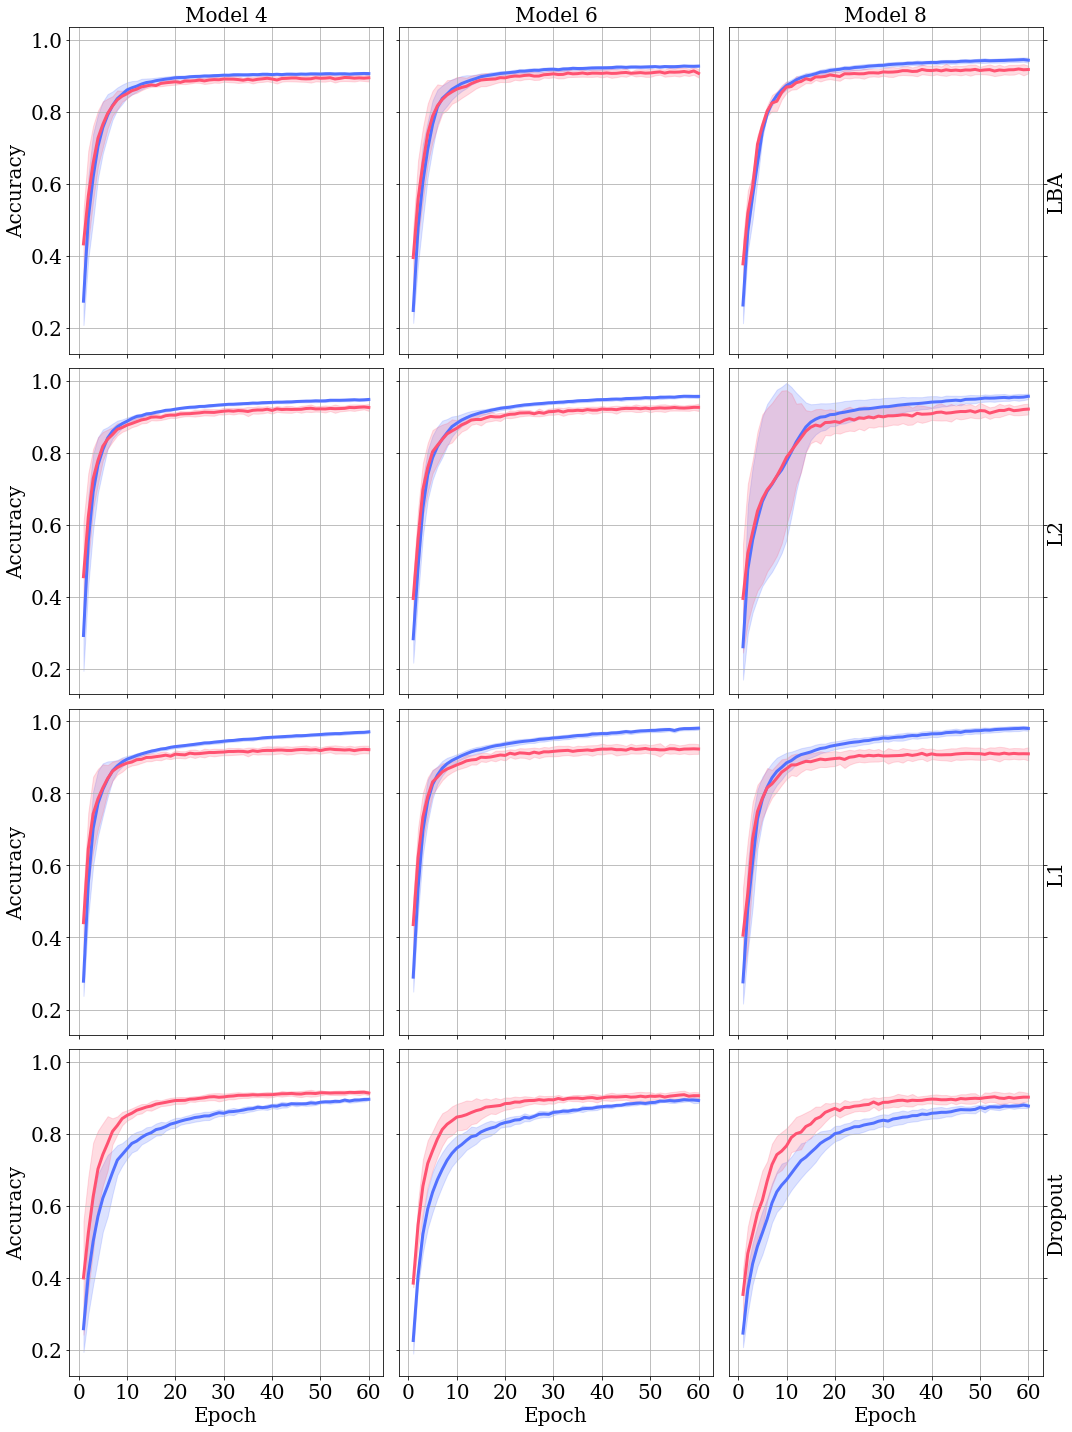

In [ ]:
n_epochs = 60
fig, ax = plt.subplots(nrows=4, ncols=3, 
                       sharex=True, sharey=True, 
                       figsize=(15, 20))

for i in range(4):
  for j in range(3):
    ax[i][j].set_xticks(np.arange(0, n_epochs+1, step=10))
    
for axis, skip in zip(ax[0],[4, 6, 8]): # LB
  
  Kf_eval_train_M0 = resultGeneral[skip][0] 
  Kf_eval_val_M0 = resultGeneral[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-', lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[1],[4, 6, 8]): # L2
  
  Kf_eval_train_M0 = resultGeneralL2[skip][0] 
  Kf_eval_val_M0 = resultGeneralL2[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-', lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[2],[4, 6, 8]): # L1
  
  Kf_eval_train_M0 = resultGeneralL1[skip][0] 
  Kf_eval_val_M0 = resultGeneralL1[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-', lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[3],[4, 6, 8]): # DO
  
  Kf_eval_train_M0 = resultGeneralDO[skip][0] 
  Kf_eval_val_M0 = resultGeneralDO[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-',lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, col in zip(ax[0], ['Model 4', 'Model 6', 'Model 8']):
    axis.set_title(col, fontsize=20)

for axis in ax[3]:
  axis.set_xlabel('Epoch', fontsize = 20)

for axis in ax[:,0]:
  axis.set_ylabel('Accuracy', fontsize = 20)

for axis, row in zip(ax[:,2], ['LBA', 'L2', 'L1', 'Dropout']):
    axis.set_ylabel(row, rotation=90, fontsize=20)
    axis.yaxis.set_label_position("right")
    axis.yaxis.tick_right()
    axis = plt.gca()
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
plt.savefig('AccEA.pdf') 

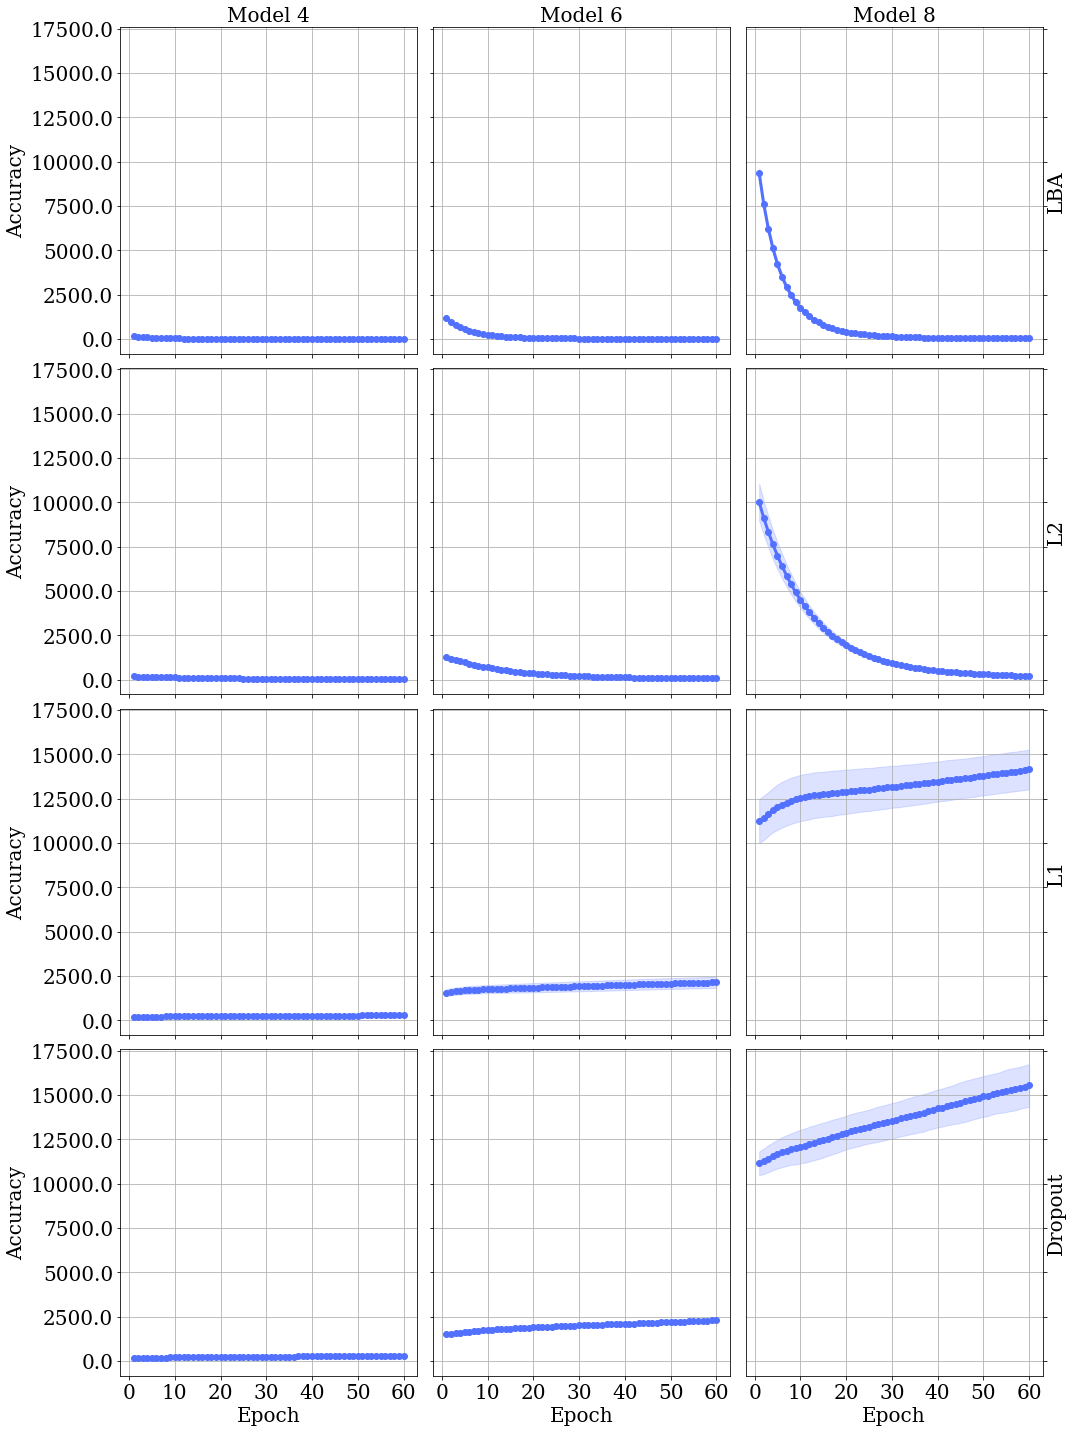

In [ ]:
n_epochs = 60
fig, ax = plt.subplots(nrows=4, ncols=3, 
                       sharex=True, sharey=True, 
                       figsize=(15, 20))

for i in range(4):
  for j in range(3):
    ax[i][j].set_xticks(np.arange(0, n_epochs+1, step=10))
    
for axis, skip in zip(ax[0],[4, 6, 8]): # LB
  
  Kf_LB_M0 = resultGeneral[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, (LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  axis.fill_between(epoch_vec, (LB_std_positive_M0),
                    (LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')

  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[1],[4, 6, 8]): # L2
  
  Kf_LB_M0 = resultGeneralL2[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, (LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  axis.fill_between(epoch_vec, (LB_std_positive_M0),
                    (LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[2],[4, 6, 8]): # L1
  
  Kf_LB_M0 = resultGeneralL1[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, (LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  axis.fill_between(epoch_vec, (LB_std_positive_M0), 
                    (LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[3],[4, 6, 8]): # DO
  
  Kf_LB_M0 = resultGeneralDO[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, (LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  axis.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, col in zip(ax[0], ['Model 4', 'Model 6', 'Model 8']):
    axis.set_title(col, fontsize=20)

for axis in ax[3]:
  axis.set_xlabel('Epoch', fontsize = 20)

for axis in ax[:,0]:
  axis.set_ylabel('Accuracy', fontsize = 20)

for axis, row in zip(ax[:,2], ['LBA', 'L2', 'L1', 'Dropout']):
    axis.set_ylabel(row, rotation=90, fontsize=20)
    axis.yaxis.set_label_position("right")
    axis.yaxis.tick_right()
    axis = plt.gca()
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
plt.savefig('LBEA.pdf')

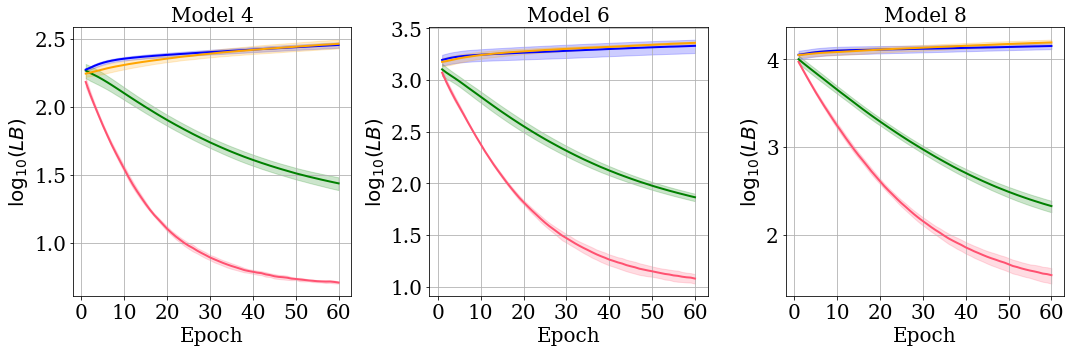

In [ ]:
n_epochs = 60
fig, ax = plt.subplots(nrows=1, ncols=3, 
                       sharex=True, 
                       figsize=(15, 5))

for axis in ax:
  axis.set_xticks(np.arange(0, n_epochs+1, step=10))
  axis.set_ylabel(r'$\log_{10} (LB)$',fontsize=20)
  axis.set_xlabel('Epoch',fontsize=20)
for axis, col in zip(ax, ['Model 4', 'Model 6', 'Model 8']):
    axis.set_title(col, fontsize=20)

for axis, skip in zip(ax,[4, 6, 8]): # LB
  
  Kf_LB_M0 = resultGeneral[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), '#ff5271', linestyle = "-",
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#ff5271',
                  label = r'$\sigma$ Lipschitz Bound')

  Kf_LB_M0 = resultGeneralL2[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), 'g', linestyle = "-", 
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color='g',
                  label = r'$\sigma$ Lipschitz Bound')
  
  Kf_LB_M0 = resultGeneralL1[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), 'blue',linestyle = "-",
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color =  'blue',
                  label = r'$\sigma$ Lipschitz Bound')

  Kf_LB_M0 = resultGeneralDO[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), 'orange', linestyle = "-",
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = 'orange',
                  label = r'$\sigma$ Lipschitz Bound')

  axis.grid()

plt.tight_layout()
plt.savefig('LB.pdf')